# Preliminary

In [1]:
import numpy as np

def slow_matrix_product(mat1, mat2):
    """Multiply two matrices."""
    assert mat1.shape[1] == mat2.shape[0]
    result = []
    for c in range(mat2.shape[1]):
        column = []
        for r in range(mat1.shape[0]):
            value = 0
            for i in range(mat1.shape[1]):
                value += mat1[r, i] * mat2[i, c]
            column.append(value)
        result.append(column)
    return np.array(result).transpose()

matrix1 = np.random.rand(10, 10)
matrix2 = np.random.rand(10, 10)

# This is very long in the console, so I'm not going to show this.
# print(slow_matrix_product(matrix1, matrix2))
# print(matrix1 @ matrix2)

np.allclose(slow_matrix_product(matrix1, matrix2), matrix1 @ matrix2)

True

# Part 1: A better function

In [2]:
def faster_matrix_product(mat1, mat2):
    """
    Multiply two matrices using successive matrix-vector calculations.
    """
    # This allows other data types such as strings, etc. to be input as mat1, mat2.
    mat1 = np.matrix(mat1)
    mat2 = np.matrix(mat2)
    # Check if matrices are multiplicatively conformable.
    if mat1.shape[1] != mat2.shape[0]:
        raise ValueError("#col of mat1 should equal #row of mat2")
    # Originally, np.hstack was used instead of initialising an empty matrix beforehand. Unfortunately, hstack has problems when it is passed numba's special array type.
    result = np.empty((mat1.shape[1], mat2.shape[0]))
    for c in range(mat1.shape[1]):
        # This is matrix-vector multiplication, which is allowed after clarification from Matthew Scroggs.
        column = np.dot(mat1, mat2[:, c])
        result[:, c] = column.flatten()
    return result

# An example of one without using matrix-vector multiplication. It's much slower than the above function, but still faster than slow_matrix_product. For 1000 100x100 matrices, "slow" takes 400s, "sorta_slow" 100s, "faster" 1s, "@" 0.2s.
def sorta_slow_matrix_product(mat1, mat2):
    assert mat1.shape[1] == mat2.shape[0]
    result = np.empty((mat1.shape[1], mat2.shape[0]))
    for c in range(mat1.shape[1]):
        for r in range(mat2.shape[0]):
            result[r, c] = np.dot(mat1[r, :], mat2[:, c]).flatten()
    return result

In [3]:
def _test(function):
    """
    Tests whether a function is equivalent to matrix multiplication using `@`
    """
    # generate random matrices of 2x2 ... 6x6
    for n in range(2, 6):
        m1 = np.random.rand(n, n)
        m2 = np.random.rand(n, n)
        my_result = function(m1, m2)
        correct_result = m1 @ m2
        assert np.allclose(my_result, correct_result)
    # If python reaches this line, no error has been raised
    return "Looks good"

_test(faster_matrix_product)

'Looks good'

This function, `faster_matrix_product` is better than `slow_matrix_product` because

1. Using `np.dot` in line 16 allows NumPy to create a specialised array with values in consecutive memory addresses, which speeds up calculations using SIMD. In addition, NumPy arrays contain actual values rather than Python lists which contain pointers to other values in memory (not necessarily consecutive), which reduces data transfer delays.
2. It contains a specialised error message which allows exceptions to be better understood by the user, and has more flexible parameters which allows matrices to be input via other data types, eg. strings through `input()`.

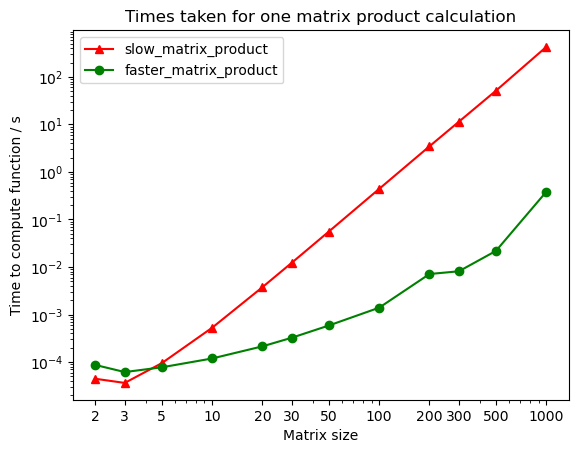

In [4]:
%matplotlib inline
import matplotlib.pylab as plt
from timeit import timeit

def slow_matrix_product_rand(N):
    """
    Calculates the matrix product of two random NxN matrices using `slow_matrix_product`.
    """
    m1 = np.random.rand(N, N)
    m2 = np.random.rand(N, N)
    return slow_matrix_product(m1, m2)

def faster_matrix_product_rand(N):
    """
    Calculates the matrix product of two random NxN matrices using `faster_matrix_product`.
    """
    m1 = np.random.rand(N, N)
    m2 = np.random.rand(N, N)
    return faster_matrix_product(m1, m2)

def time_matrix_product():
    """
    Times `slow_matrix_product_rand` and `faster_matrix_product_rand` using timeit. Requires `N` to be defined in `__main__`.
    """
    t_slow = timeit("slow_matrix_product_rand(N)", "from __main__ import slow_matrix_product_rand, N", number=1)
    t_faster = timeit("faster_matrix_product_rand(N)", "from __main__ import faster_matrix_product_rand, N", number=1)
    return([t_slow, t_faster])

matrix_sizes = [2, 3, 5, 10, 20, 30, 50, 100, 200, 300, 500, 1000]
times = []
for N in matrix_sizes:
    times.append(time_matrix_product())
times = np.array(times)
    
plt.plot(matrix_sizes, times[:, 0], "r^-")
plt.plot(matrix_sizes, times[:, 1], "go-")
plt.xscale("log")
plt.yscale("log")

plt.xticks(matrix_sizes, matrix_sizes)
plt.xlabel("Matrix size")
plt.ylabel("Time to compute function / s")
plt.legend(["slow_matrix_product", "faster_matrix_product"])
plt.title("Times taken for one matrix product calculation")
plt.show()

# Part 2: speeding it up with Numba

C:\Users\User\AppData\Local\Temp\ipykernel_16920\2922460910.py:17: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  column = np.dot(mat1, mat2[:, c])


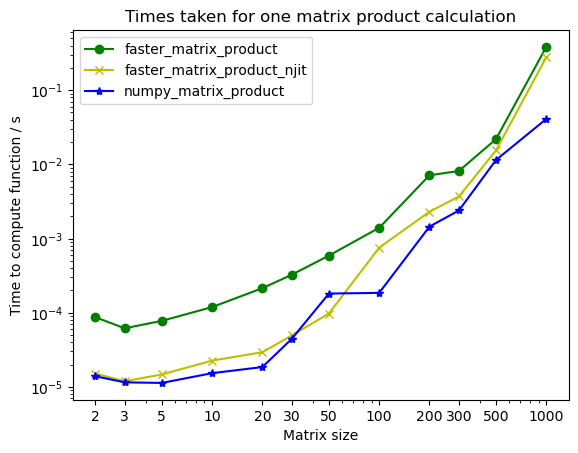

In [5]:
from numba import njit

@njit
def faster_matrix_product_njit(mat1, mat2):
    """
    Multiply two matrices using successive matrix-vector calculations, using Numba's just-in-time compilation.
    """
    # Unfortunately, numba does not support np.matrix.
    # mat1 = np.matrix(mat1)
    # mat2 = np.matrix(mat2)
    # This is the same function as before, so I have removed comments.
    if mat1.shape[1] != mat2.shape[0]:
        raise ValueError("#col of mat1 should equal #row of mat2")
    
    result = np.empty((mat1.shape[1], mat2.shape[0]))
    for c in range(mat1.shape[1]):
        column = np.dot(mat1, mat2[:, c])
        result[:, c] = column.flatten()
    return result

# Compile the function beforehand so it doesn't interfere with the timing. As a bonus, tests if the function works.
assert _test(faster_matrix_product_njit) == "Looks good"

def faster_matrix_product_njit_rand(N):
    """
    Calculates the matrix product of two random NxN matrices using `faster_matrix_product_njit`.
    """
    m1 = np.random.rand(N, N)
    m2 = np.random.rand(N, N)
    return faster_matrix_product_njit(m1, m2)

def numpy_matrix_product_rand(N):
    """
    Calculates the matrix product of two random NxN matrices using NumPy.
    """
    m1 = np.random.rand(N, N)
    m2 = np.random.rand(N, N)
    return m1 @ m2

def time_matrix_product_2():
    """
    Times `faster_matrix_product_njit_rand`, and `numpy_matrix_product_rand` using timeit. Requires `N` to be defined in `__main__`.
    """
    t_faster_njit = timeit("faster_matrix_product_njit_rand(N)", "from __main__ import faster_matrix_product_njit_rand, N", number=1)
    t_numpy = timeit("numpy_matrix_product_rand(N)", "from __main__ import numpy_matrix_product_rand, N", number=1)
    return([t_faster_njit, t_numpy])

times_2 = []
for N in matrix_sizes:
    times_2.append(time_matrix_product_2())
times_2 = np.array(times_2)

plt.plot(matrix_sizes, times[:, 1], "go-")
plt.plot(matrix_sizes, times_2[:, 0], "yx-")
plt.plot(matrix_sizes, times_2[:, 1], "b*-")
plt.xscale("log")
plt.yscale("log")

plt.xticks(matrix_sizes, matrix_sizes)
plt.xlabel("Matrix size")
plt.ylabel("Time to compute function / s")
plt.legend(["faster_matrix_product", "faster_matrix_product_njit", "numpy_matrix_product"])
plt.title("Times taken for one matrix product calculation")
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_16920\2922460910.py:17: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, F), array(float64, 1d, A))
  column = np.dot(mat1, mat2[:, c])


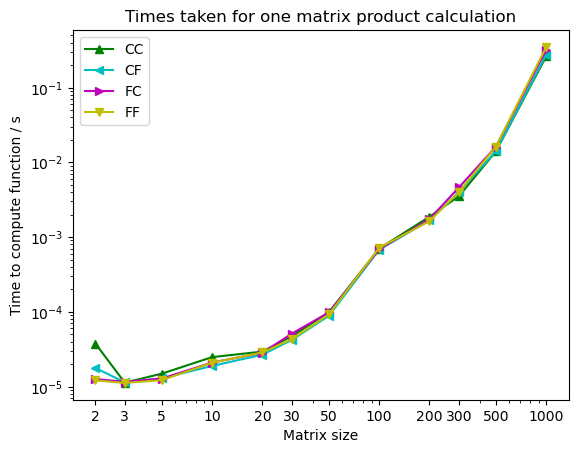

In [6]:
def faster_matrix_product_njit_rand_cc(N):
    """
    Calculates the matrix product of two random NxN matrices using `faster_matrix_product_njit` and both matrices having C-type ordering
    """
    m1 = np.ascontiguousarray(np.random.rand(N, N))
    m2 = np.ascontiguousarray(np.random.rand(N, N))
    return faster_matrix_product_njit(m1, m2)

def faster_matrix_product_njit_rand_cf(N):
    """
    Calculates the matrix product of two random NxN matrices using `faster_matrix_product_njit` and first matrix having C-type ordering, second Fortan-type
    """
    m1 = np.ascontiguousarray(np.random.rand(N, N))
    m2 = np.asfortranarray(np.random.rand(N, N))
    return faster_matrix_product_njit(m1, m2)

def faster_matrix_product_njit_rand_fc(N):
    """
    Calculates the matrix product of two random NxN matrices using `faster_matrix_product_njit` and first matrix having Fortran-type ordering, second C-type
    """
    m1 = np.asfortranarray(np.random.rand(N, N))
    m2 = np.ascontiguousarray(np.random.rand(N, N))
    return faster_matrix_product_njit(m1, m2)

def faster_matrix_product_njit_rand_ff(N):
    """
    Calculates the matrix product of two random NxN matrices using `faster_matrix_product_njit` and and both matrices having Fortran-type ordering
    """
    m1 = np.asfortranarray(np.random.rand(N, N))
    m2 = np.asfortranarray(np.random.rand(N, N))
    return faster_matrix_product_njit(m1, m2)

def time_matrix_product_3():
    """
    Times `faster_matrix_product_njit_rand_<xx>` for <xx> in [cc, cf, fc, ff] using timeit. Requires `N` to be defined in `__main__`.
    """
    t_cc = timeit("faster_matrix_product_njit_rand_cc(N)", "from __main__ import faster_matrix_product_njit_rand_cc, N", number=1)
    t_cf = timeit("faster_matrix_product_njit_rand_cf(N)", "from __main__ import faster_matrix_product_njit_rand_cf, N", number=1)
    t_fc = timeit("faster_matrix_product_njit_rand_fc(N)", "from __main__ import faster_matrix_product_njit_rand_fc, N", number=1)
    t_ff = timeit("faster_matrix_product_njit_rand_ff(N)", "from __main__ import faster_matrix_product_njit_rand_ff, N", number=1)
    return([t_cc, t_cf, t_fc, t_ff])

# Compile the functions beforehand so it doesn't interfere with the timing.
N = 2
time_matrix_product_3()

times_3 = []
for N in matrix_sizes:
    times_3.append(time_matrix_product_3())
times_3 = np.array(times_3)

plt.plot(matrix_sizes, times_3[:, 0], "g^-")
plt.plot(matrix_sizes, times_3[:, 1], "c<-")
plt.plot(matrix_sizes, times_3[:, 2], "m>-")
plt.plot(matrix_sizes, times_3[:, 3], "yv-")
plt.xscale("log")
plt.yscale("log")

plt.xticks(matrix_sizes, matrix_sizes)
plt.xlabel("Matrix size")
plt.ylabel("Time to compute function / s")
plt.legend(["CC", "CF", "FC", "FF"])
plt.title("Times taken for one matrix product calculation")
plt.show()

While it appears that there are no significant differences between the functions (perhaps due to the use of NumPy's efficient matrix-vector calculations), we expect the CF function to have an advantage over the others. This is because for a given square in the matrix $\mathbf{C} = \mathbf{AB}$ we have

$$ C_{ij} = \sum_{k=1}^n a_{ik}b_{kj},$$

where $k$ is being iterated over the columns of each row for $\mathbf{A}$, which are stored successively in C-type memory layout, and over the rows of each column for $\mathbf{B}$, which are stored successively in FORTRAN-type memory layout; due to SIMD acceleration, we expect calculations over memory spaces closer together to be faster.